In [43]:
import re
import json
import networkx as nx
import matplotlib.pyplot as plt


def parse_name(name):
    """Takes a name string in any format and returns the first name, last name, and middle initial."""
    # Remove leading/trailing whitespace
    name = name.strip()

    # Define regular expression patterns for different name formats
    patterns = [
        r'^(?P<first>\w+)\s+(?P<middle>\w\.)\s+(?P<last>\w+)$',  # Firstname M. Lastname
        r'^(?P<first>\w+)\s+(?P<last>\w+)$',                     # Firstname Lastname
        r'^(?P<last>\w+),\s+(?P<first>\w+)$',                    # Lastname, Firstname
        r'^(?P<last>\w+),\s+(?P<first>\w+)\s+(?P<middle>\w\.)$'  # Lastname, Firstname M.
    ]

    # Iterate over the patterns and try to match the name
    for pattern in patterns:
        match = re.match(pattern, name)
        if match:
            # Extract the matched groups
            first = match.group('first')
            last = match.group('last')
            middle = match.group('middle') if 'middle' in match.groupdict() else ''

            # Capitalize the first letter and lowercase the rest
            first = first.capitalize()
            last = last.capitalize()
            middle = middle.capitalize() if middle else None

            return first, last, middle

    # If no match is found, return None for all fields
    return None, None, None


class Group:
    """Class to store a group of Person objects and the types of relationships among them."""
    def __init__(self, filename=None):
        """Optionally initialize the group using an existing json file."""
        self.relationships = dict()
        self.people = dict()
        self.graphs = dict()
        if filename:
            load_people_from_file(self, filename)

    def save_group_to_file(self, filename):
        """Save the relationships and people in the group to a json file."""
        data = {
            'relationships': self.relationships,
            'people': {
                fullname: {
                    attr: getattr(person, attr)
                    for attr in dir(person)
                    if not attr.startswith('__') and not callable(getattr(person, attr)) and attr != 'group'
                }
                for fullname, person in self.people.items()
            }
        }
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)

    def update_relationship_graphs(self):
        """Create a graph for each type of relationship in the group."""
        # Create separate graphs for each relationship type
        for relationship, direction in self.relationships.items():
            if relationship not in self.graphs:
                if direction == 'undirected':
                    self.graphs[relationship] = nx.Graph()
                else:
                    self.graphs[relationship] = nx.DiGraph()

            # Add people as nodes
            for fullname in self.people:
                self.graphs[relationship].add_node(fullname)

            # Add relationships as edges
            for person in self.people.values():
                if hasattr(person, relationship):
                    for related_person_fullname in getattr(person, relationship):
                        self.graphs[relationship].add_edge(person.fullname, related_person_fullname)
    
    def plot_relationship_graph(self, relationship):
        """Plot a graph of a type of relationship."""
        plt.figure(figsize=(8, 6))
        nx.draw(self.graphs[relationship], with_labels=True, node_size=500, node_color='skyblue', font_size=12, font_weight='bold')
        plt.title(f"{relationship.capitalize()} Relationship Graph")
        plt.show()
        

class Person:
    """Class to represent a person and list their relationships."""
    def __init__(self, name, group):
        """A Person is initialized using a name and the Group they belong to."""
        # Parse name
        self.firstname, self.lastname, self.middle = parse_name(name)
        assert self.firstname and self.lastname, f'Person must be initialized with a valid full name; the name "name" is invalid.'
        self.fullname = ' '.join(filter(None, [self.firstname, self.middle, self.lastname]))

        # Add person to group
        assert isinstance(group, Group), "Person must be initialized with a valid Group." 
        if self.fullname not in group.people:
            group.people[self.fullname] = self
        self.group = group

    def add_undirected_relationship(self, name, relationship):
        """Add a mutual relationship (such as 'friends') to the Person 'name'."""
        # Store type of relationship in group relationships
        if relationship not in self.group.relationships:
            self.group.relationships[relationship] = 'undirected'
        else:
            assert self.group.relationships[relationship] == 'undirected', f'Relationship "{relationship}" is already saved as directed.'

        # Initialize self relationship
        if not hasattr(self, relationship):
            setattr(self, relationship, [])

        # Find target
        target = Person(name, self.group)
        target_name = target.fullname
        if target_name in self.group.people:
            target = self.group.people[target_name]

        # Set the relationship of both self and target
        if target_name not in getattr(self, relationship):
            getattr(self, relationship).append(target_name)
            target.add_undirected_relationship(self.fullname, relationship)

    def add_directed_relationship(self, name, relationship):
        """Add a directed relationship (such as 'children')."""
        # Store type of relationship in group relationships
        if relationship not in self.group.relationships:
            self.group.relationships[relationship] = 'directed'
        else:
            assert self.group.relationships[relationship] == 'directed', f'Relationship "{relationship}" is already saved as undirected.'
        
        # Initialize self relationship
        if not hasattr(self, relationship):
            setattr(self, relationship, [])

        # Find target
        target = Person(name, self.group)
        target_name = target.fullname
        if target_name in self.group.people:
            target = self.group.people[target_name]
        
        # Set the relationship of self to target
        if target_name not in getattr(self, relationship):
            getattr(self, relationship).append(target_name)


def load_people_from_file(group, filename):
    """Load Person objects from saved json file into Group object."""
    try:
        with open(filename, 'r') as file:
            data = json.load(file)
            relationships = data.get('relationships', {})
            for relationship, kind in relationships.items():
                if relationship in group.relationships:
                    # If a relationship exists in both the saved group and the existing group, ensure they have the same type
                    assert kind == group.relationships[relationship], f'Conflicting relationship: existing relationship "{relationship}" is {group.relationships[relationship]}, while new relationship "{relationship}" is {kind}'
                else:
                    group.relationships[relationship] = kind
            # Create new Person objects for each person in the saved group
            for fullname, attrs in data.get('people', {}).items():
                person = Person(fullname, group)
                for attr, values in attrs.items():
                    setattr(person, attr, values)
    except FileNotFoundError:
        print(f"File '{filename}' not found.")

In [44]:
# Example usage
group = Group()
john = Person('John Doe', group)
jane = Person('Jane Smith', group)
john.add_undirected_relationship('Jane Smith', 'friends')
john.add_directed_relationship('Hank Doe', 'children')
print(group.relationships, group.people)
group.save_group_to_file('test_people.json')
group2 = Group('test_people.json')
print(group2.relationships, group2.people)

{'friends': 'undirected', 'children': 'directed'} {'John Doe': <__main__.Person object at 0x13526f1d0>, 'Jane Smith': <__main__.Person object at 0x13526ee70>, 'Hank Doe': <__main__.Person object at 0x13526e6f0>}
{'friends': 'undirected', 'children': 'directed'} {'John Doe': <__main__.Person object at 0x13526e4b0>, 'Jane Smith': <__main__.Person object at 0x13526efc0>, 'Hank Doe': <__main__.Person object at 0x13526d970>}


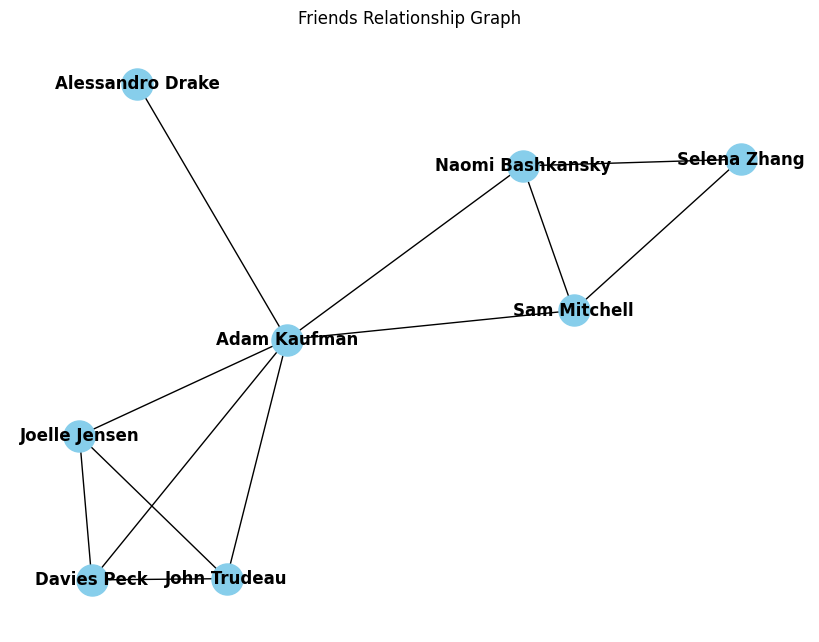

In [45]:
# Example usage
adam_friends = Group()
ghs = ['John Trudeau', 'Joelle Jensen', 'Davies Peck']
ai = ['Sam Mitchell', 'Naomi Bashkansky']
hahvahd = ['Alessandro Drake']
for name in ghs + ai + hahvahd:
    person = Person(name, adam_friends)
    person.add_undirected_relationship('Adam Kaufman', 'friends')

for name in ghs:
    for other_name in ghs:
        if name != other_name:
            adam_friends.people[name].add_undirected_relationship(other_name, 'friends')

selena = Person('Selena Zhang', adam_friends)
for name in ai:
    selena.add_undirected_relationship(name, 'friends')

adam_friends.people['Naomi Bashkansky'].add_undirected_relationship('Sam Mitchell', 'friends')

adam_friends.update_relationship_graphs()
adam_friends.plot_relationship_graph('friends')